# 0.0. IMPORTS 

## 0.1. Libries

In [1]:
import psycopg2          as pg
import pandas            as pd
import pandas.io.sql     as psql
import numpy             as np
import seaborn           as sns
import matplotlib.pyplot as plt
import scikitplot        as skplt

from sklearn import preprocessing   as pp
from sklearn import model_selection as ms
from sklearn import ensemble        as en
from sklearn import neighbors       as ng
from sklearn import linear_model    as lm


## 0.2. Helper Functions

## 0.3.  Loading Data

### 0.3.1 Data Import from Data Base

In [2]:
# Credentials BD
#host = 'comunidade-ds-postgres.c50pcakiuwi3.us-east-1.rds.amazonaws.com'
#port = 5432
#database = 'comunidadedsdb'
#user = 'member'
#pwd = 'cdspa'

##Create conection BD
#conn = pg.connect( user=user,
#            password=pwd,
#            host=host,
#            port=port,
#            database=database )

##Join tables
#query_tables_users = """
#    SELECT *
#    FROM pa004.users u LEFT JOIN pa004.vehicle   v ON ( u.id = v.id )
#                       LEFT JOIN pa004.insurance i ON ( u.id = i.id )  
#    WHERE u.age > 44
#    
#"""
#
#df_raw = pd.read_sql( query_tables_users, conn )
#
##Drop duplicates id's 
#
#df_raw = df_raw.drop( df_raw.columns[[5,9]], axis = 1)
#
##csv generate
#df_raw.to_csv('data/BD_emerge.csv', encoding='utf-8', index=False)

### 0.3.2 Loading Data

In [3]:
df_bd = pd.read_csv('data/BD_emerge.csv')
df_raw = pd.read_csv('data/train.csv')

# 1. DATA DESCRIPTION

In [4]:
df1 = df_raw.copy()

## Description Columns:

- Id: identificador único do cliente.

- Gender: gênero do cliente.

- Age: idade do cliente.

- Driving License: 0, o cliente não tem permissão para dirigir e 1, o cliente tem para dirigir ( CNH – Carteira
Nacional de Habilitação )

- Region Code: código da região do cliente.

- Previously Insured: 0, o cliente não tem seguro de automóvel e 1, o cliente já tem seguro de automóvel.

- vehicle Age: idade do veículo.

- Vehicle Damage: 0, cliente nunca teve seu veículo danificado no passado e 1, cliente já teve seu veículo
danificado no passado.

- Anual Premium: quantidade que o cliente pagou à empresa pelo seguro de saúde anual.

- Policy sales channel: código anônimo para o canal de contato com o cliente.

- Vintage: número de dias que o cliente se associou à empresa através da compra do seguro de saúde.

- Response: 0, o cliente não tem interesse e 1, o cliente tem interesse.

## 1.1. Rename Columns 

In [5]:
 cols_new = ['id', 'gender', 'age', 'driving_license', 'region_code', 'previously_insured', 'vehicle_age', 
            'vehicle_damage', 'annual_premium', 'policy_sales_channel', 'vintage', 'response']

# rename 
df1.columns = cols_new

## 1.2. Data Dimensions 

In [6]:
print( 'Number of Rows: {}'.format( df1.shape[0] ) )
print( 'Number of cols: {}'.format( df1.shape[1] ) )


Number of Rows: 381109
Number of cols: 12


## 1.3. Data Types

In [7]:
df1.dtypes

id                        int64
gender                   object
age                       int64
driving_license           int64
region_code             float64
previously_insured        int64
vehicle_age              object
vehicle_damage           object
annual_premium          float64
policy_sales_channel    float64
vintage                   int64
response                  int64
dtype: object

## 1.4. Check NA

In [8]:
df1.isna().sum()

id                      0
gender                  0
age                     0
driving_license         0
region_code             0
previously_insured      0
vehicle_age             0
vehicle_damage          0
annual_premium          0
policy_sales_channel    0
vintage                 0
response                0
dtype: int64

## 1.5. Desctiptive Statistical

In [9]:
#Separate into numeric and categorical
num_attributes = df1.select_dtypes(include =['int64', 'float64'])
cat_attributes = df1.select_dtypes( include = ['object'])


### 1.5.1. Numerical Atributes

In [10]:
#Central tendency - mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

#Dispersion - std, min, max, range, skew, kurtosis 
d1 = pd.DataFrame( num_attributes.apply( np.std) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# Concatenate
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id,1.0,381109.0,381108.0,190555.000000,190555.0,110016.691870,9.443274e-16,-1.200000
1,age,20.0,85.0,65.0,38.822584,36.0,15.511591,6.725390e-01,-0.565655
2,driving_license,0.0,1.0,1.0,0.997869,1.0,0.046109,-2.159518e+01,464.354302
3,region_code,0.0,52.0,52.0,26.388807,28.0,13.229871,-1.152664e-01,-0.867857
4,previously_insured,0.0,1.0,1.0,0.458210,0.0,0.498251,1.677471e-01,-1.971871
5,annual_premium,2630.0,540165.0,537535.0,30564.389581,31669.0,17213.132474,1.766087e+00,34.004569
6,policy_sales_channel,1.0,163.0,162.0,112.034295,133.0,54.203924,-9.000081e-01,-0.970810
7,vintage,10.0,299.0,289.0,154.347397,154.0,83.671194,3.029517e-03,-1.200688
8,response,0.0,1.0,1.0,0.122563,0.0,0.327935,2.301906e+00,3.298788


### 1.5.2 Categorical Atributes

In [11]:
cat_attributes.columns

Index(['gender', 'vehicle_age', 'vehicle_damage'], dtype='object')

# 2.0. FEATURE ENGINEERING

In [12]:
df2 = df1.copy()

-  2.1. Mapa Mental de Hipoteses
-  2.2. Criação das Hipotéses(Loja, Produto, tempo)
-  2.3. Hipoteses Finais. 
-  2.4. Feature Engineering

In [13]:
#Vehicle age
df2['vehicle_age'] = df2['vehicle_age'].apply( lambda x: 'over_2_years' if x == '> 2 Years'
                                               else 'between_1_2_year'  if x == '1-2 Year'
                                               else 'below_1_year')
#Vehicle damage
df2['vehicle_damage'] = df2['vehicle_damage'].apply( lambda x: 1 if x == 'yes' 
                                                    else 0 )

# 3.0. Data Filtering

In [14]:
df3 = df2.copy()

# 4.0. EDA

In [15]:
df4 = df3.copy()

Faze univariada, bivariada, teste de hipoteses... 

## 4.1. Univariate Analysis

Em um projeto de classificação o objetivo é encontrar quais features tem uma separação natural ou mais separadas naturalmente para ajudar o modelo. O modelo sempre quer descobrir um corte no espaço que consegue separe quem tem interesse no produto e quem não tem interesse no produto. 
Quando usamos variáveis unidirecional, queremos plotar uma distribuição e olha esta projeção no eixo x, para dizer se são misturadas ou não. 
Do ponto gráfico podemos analisar diferença de médias, dos quartis, sobreposição entre distribuição. Assim podemos ter uma idéia se a váriavel irá 'bagunçar' ou 'separar' o dataset. Lembrando que o interesse aqui é encontrar as variáveis separadas entre si. 

### - Variable "age"
Possui relevância para o modelo

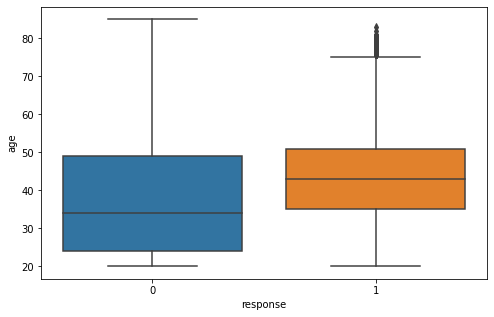

In [16]:
#age
sns.boxplot( x= 'response' , y= 'age', data= df4 ).figure.set_size_inches(8,5);

> Interpretação do boxplot variavel ageXresponse: 
> - No grupo de pessoas que não estão interessados, temos a mediana próximo dos 35 anos, o primeiro ao terceiro >quartis estão dentro do intervalo de 25 a 50 anos.
>- No grupo de pessoas que estão interessados, temos a mediana próxima a 45 anos, e o primeiro quartil estã acima da mediana do primeiro grupo, vemos uma concentração nos primeiro e terceiro quartis na faixa de 35 e 50.
>- Numa primeira analise vemos que a um interesse maior das pessoas mais velhas contra as mais novas, nos indicando que esta variável pode ter importância na classificação. 

Interested People: 46710 
Not Interested People: 334399 


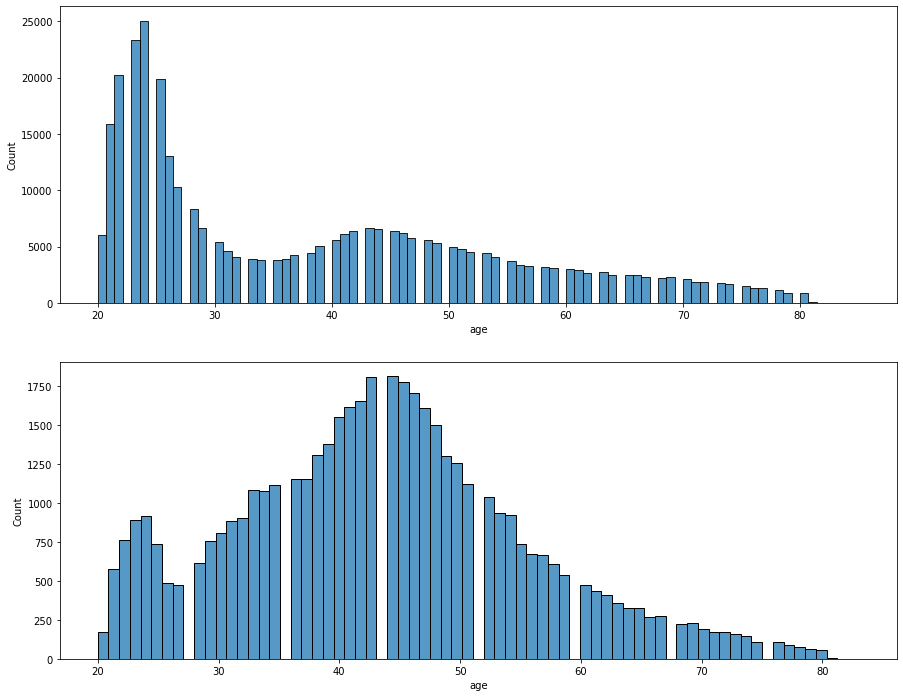

In [17]:
#Histogram not interested 
plt.subplot( 2, 1, 1 ).figure.set_size_inches(15,12);
aux0 = df4.loc[ df4['response'] == 0, 'age' ]
sns.histplot( aux0 );

#Histogram interested 
plt.subplot( 2, 1, 2 );
aux0 = df4.loc[ df4['response'] == 1, 'age' ]
sns.histplot( aux0 );
print( f"Interested People: {len(df4.loc[ df4['response'] == 1, 'age' ])} ")
print( f"Not Interested People: {len(df4.loc[ df4['response'] == 0, 'age' ])} ")

> Ao plotarmos a distribuição: 
> - Pessoas que não possuem interesse: Temos com relação a amplitude, uma concentração de pessoas muito maior por volta dos 25 anos. A distribuição não se comporta como uma normal, se assemelha mais a uma Poison. 
> - Pessoas que possuem interese: A concentração fica em torno de 40 a 50 anos, a distribuição fica masi próxima de uma distribuição normal. Percebemos que o interesse cai bastante após a idade dos 50 anos e poucas pessoas interessadas com idades da parte superior do gráfico. 
> Obs:. Temos um número muito maior de pessoas que não possuem interesse, assim podemos ficar alerta de apesar de a idade ser representativa, temos o problema de diferença de volumes entre as classes.

### - Variable "annual_premium"
Pouca relevância para o modelo

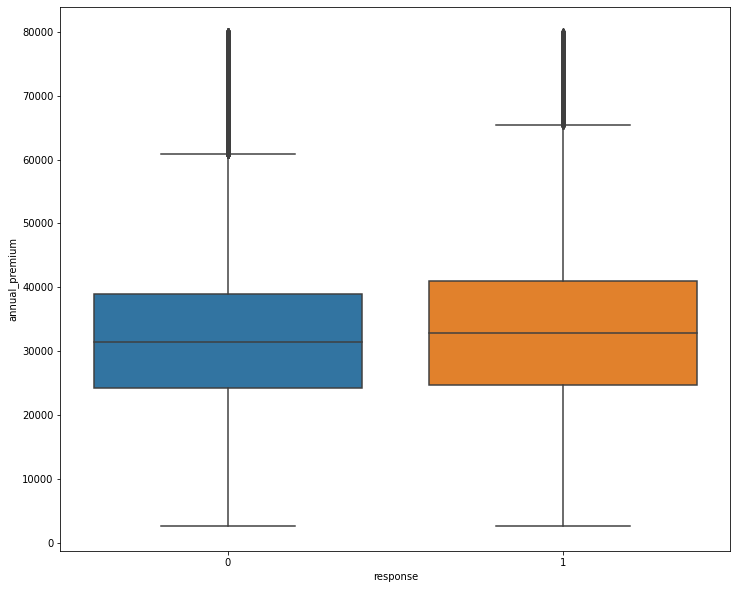

In [18]:
#annual_premium
aux =df4[df4['annual_premium'] < 80000 ]
sns.boxplot( x= 'response' , y= 'annual_premium', data= aux ).figure.set_size_inches(12,10);


> Para analisar o box-plot da 'annual_premium' foi necessário plotar diminuindo os outliers, assim plotamos com filtro de menores de 8000.
> Ao comparamos os box-plot para as duas respostas, vemos que as medianas estão muito próximas assim como a concentração entre os quartis. Assim percebemos que esta variável sozinha não nos ajudara no nosso modelo, talvez combinada com outra variável venha a ter utilidade. 

Interested People: 46710 
Not Interested People: 334399 


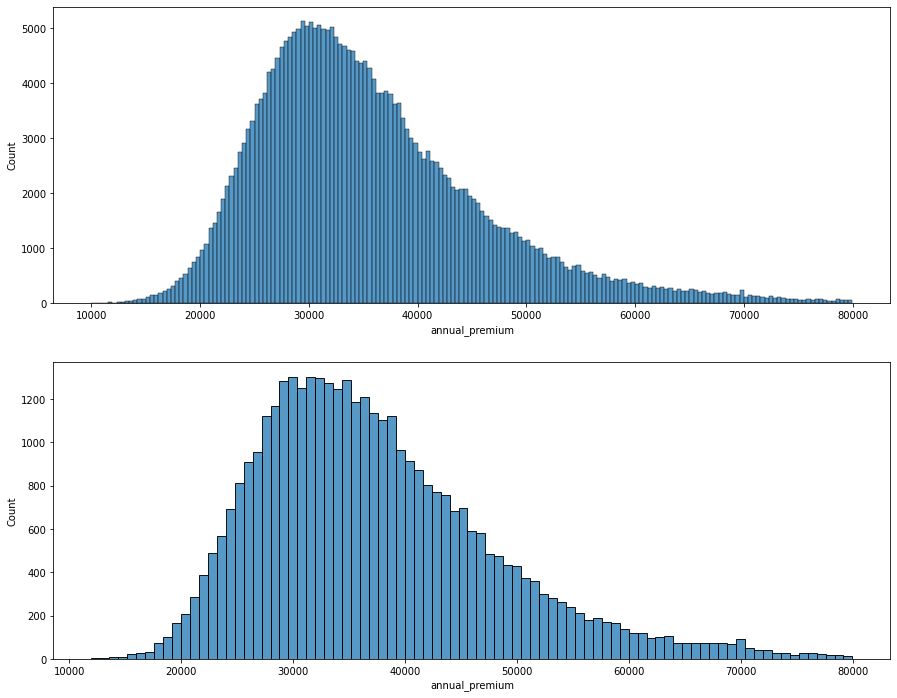

In [19]:
aux =df4[ (df4['annual_premium'] > 10000) & (df4['annual_premium'] <80000) ]

#Histogram not interessed annual_premium
plt.subplot( 2, 1, 1 ).figure.set_size_inches(15,12);
aux0 = aux.loc[ df4['response'] == 0, 'annual_premium' ]
sns.histplot( aux0 );

#Histogram annual_premium
plt.subplot( 2, 1, 2 );
aux0 = aux.loc[ df4['response'] == 1, 'annual_premium' ]
sns.histplot( aux0 );
print( f"Interested People: {len(df4.loc[ df4['response'] == 1, 'age' ])} ")
print( f"Not Interested People: {len(df4.loc[ df4['response'] == 0, 'age' ])} ")

>Ao plotar a distribuição sem os out-liers, podemos ver uma distribuição bem parecida, além de considearar que a diferenã de volume é bem alta. Logo, reafirmamos que esta variável tera pouco relevância de forma idependênte no nossso modelo podendo atrapalhar mais do que ajudar. 

### Variable "driving_license"
Não conclusiva de maneira isolada

In [20]:
#box-plot driving_license
#0 = não responderam e não dirigem
#1 = responderam e dirigem
aux = df4[['driving_license','response']].groupby('response').sum().reset_index()
aux['driving_license_perc'] = aux['driving_license']/aux['driving_license'].sum()
#sns.barplot(x='response', y = 'driving_license', data = aux);
aux

,response,driving_license,driving_license_perc
0,0,333628,0.877283
1,1,46669,0.122717


> Pouco conclusiva, analisando isoladamente temos que a maioria das pessoas entre as que dirigem(87%) não possuem interesse no seguro. Poŕém analisar esta variável sem levar em consideração outros fatores não esclarece muita coisa. Ou qual a propensão

In [21]:
pd.crosstab( df4['driving_license'], df4['response'] )

response,0,1
driving_license,,
0,771,41
1,333628,46669


In [22]:
41*100/771

5.317769130998703

> Fazendo a tabela cruzada percebemos que o interesse das pessoas que tem licensa é maior, pois temos que entre os que não possuem licensa o interesse cai para 5,3%(41 dos 812) contra 12% dos que tem carteira de motorista. 

### Variable "region_code"
pouca relevância para o modelo

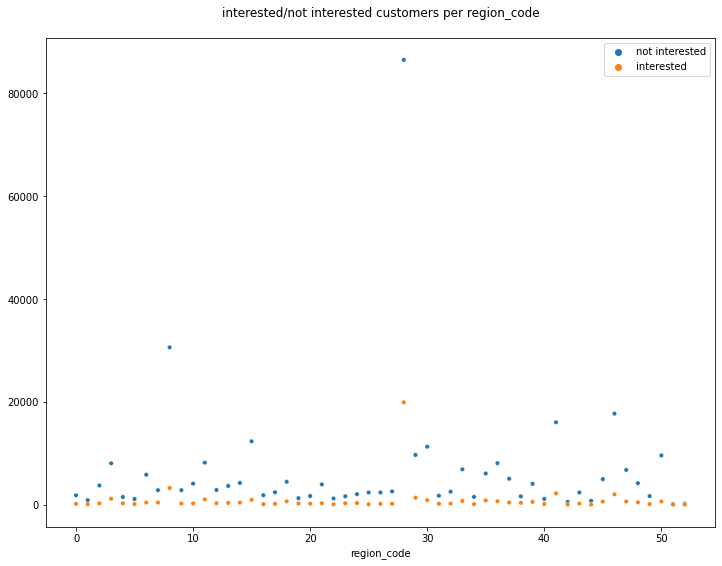

In [23]:
#plot scatterplot region_code
aux = df4[['id', 'region_code', 'response']].groupby(['region_code', 'response']).count().reset_index()
aux['response'] = aux['response'].map({0:'not interested', 1:'interested'})
ax = sns.scatterplot( x='region_code', y = 'id', hue = 'response', data = aux, s=20)
ax.set_title('interested/not interested customers per region_code\n')
ax.legend(title='')
ax.set_ylabel('')
ax.figure.set_size_inches(12,9);




> Mesmo que algumas regiões isoladamente tenha uma diferença expressiva de pessoas que tiveram interesse e não tiveram interesse, podemos ver no gráfico que a grande maioria possui um comportamento parecido. Assim, de forma isolada a variável region_code possui pouca significância para o modelo. 

### Variable "previously_insured"
Possui relevância para o modelo

In [24]:
#% tabela interesse X ja tem seguro
pd.crosstab( df4['previously_insured'], df4['response'] ).apply( lambda x: x/x.sum(), axis =1)

response,0,1
previously_insured,,
0,0.774546,0.225454
1,0.999095,0.000905


In [25]:
a = (46552*100)/(159929+46552)
b = (158*100)/(174470+158)
print( f' Pocentagem dos que não tem seguro e tem interesse: {a:.4}%')
print( f' Pocentagem dos que tem seguro e não tem interesse: {b:.3}%')

 Pocentagem dos que não tem seguro e tem interesse: 22.55%
 Pocentagem dos que tem seguro e não tem interesse: 0.0905%


>Fazendo a tabela de contigência, onde nos mostra a relação quantas pessoas que já posssuem ou não seguro de automóvel e possuem ou não iteresse no seguro oferecido. 
> Entre as pessoas que não possuem seguro, o interesse foi de 29,11% contra 0.09% das que já possuem. Aqui fica claro que esta variável é importante e relevante, pois claramente os clientes que não possuem seguro tem maior propensão a querer seguro.

### Variable "vehicle_age"
Parte relevânte para o modelo


In [26]:
df4[['vehicle_age', 'response']].value_counts( normalize = True ).reset_index().sort_values('vehicle_age')

,vehicle_age,response,0
1,below_1_year,0,0.413488
4,below_1_year,1,0.018897
0,between_1_2_year,0,0.434285
2,between_1_2_year,1,0.091328
3,over_2_years,0,0.029663
5,over_2_years,1,0.012338


> Notamos que com pessoas que possuem carros com mais de 2 anos, as respostas entre querer ou não seguro ficaram pareceidas 29% contra 12%, estes dados podem atrapalhar o modelo
> Já nos casos de carros com menos de 1 ano e entre 1 e 2 houve maior discrepância nas resposta, oq faz ter uma discriminção razoável para o modelo. 

### Variable "policy_sales_channel"
Não conclusiva

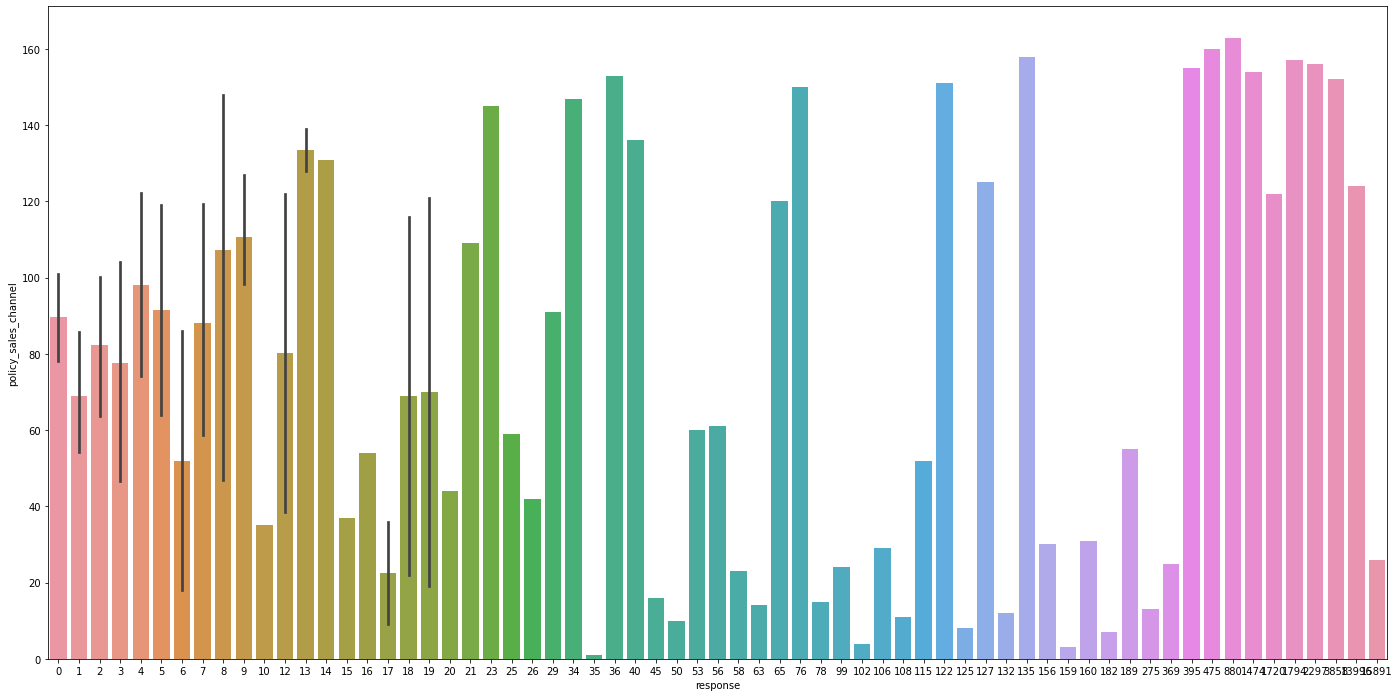

In [27]:
aux = df4[['policy_sales_channel', 'response']].groupby( 'policy_sales_channel' ).sum().reset_index()
sns.barplot( x='response', y='policy_sales_channel', data=aux ).figure.set_size_inches(24, 12)

### Variable "vintage"
Sem Relevância

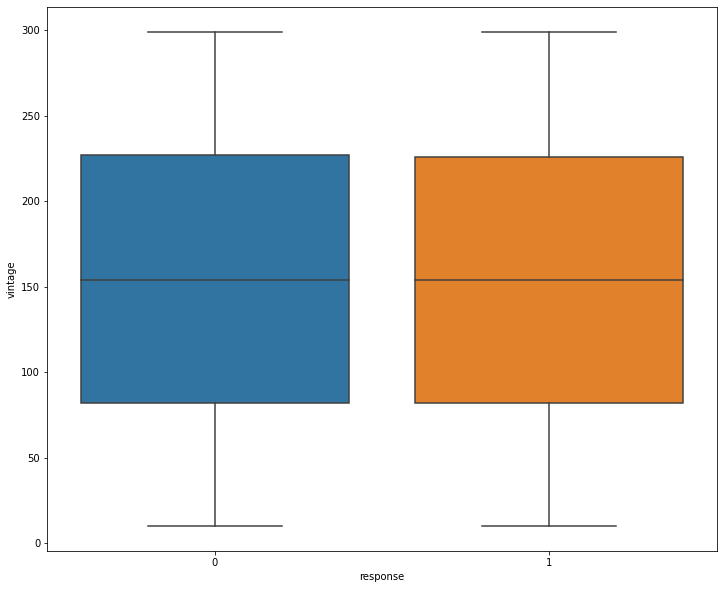

In [28]:
sns.boxplot( x= 'response' , y= 'vintage', data= df4 ).figure.set_size_inches(12,10);

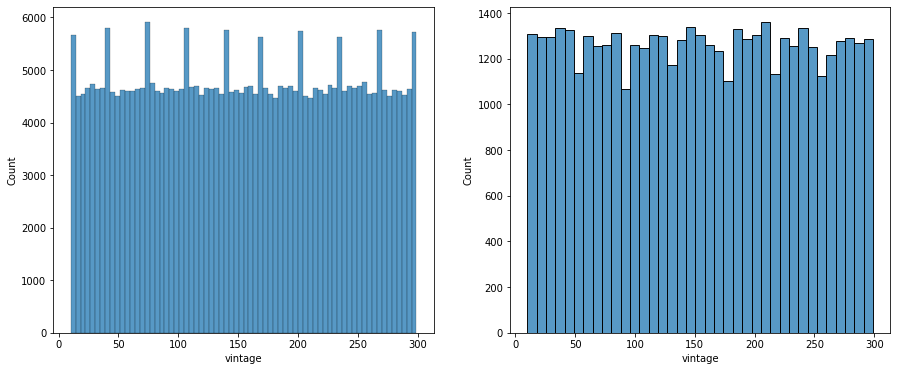

In [29]:

plt.subplot( 1, 2, 1 )
aux00 = df4.loc[df4['response'] == 0, 'vintage']
sns.histplot( aux00 ).figure.set_size_inches(12,6);

plt.subplot( 1, 2, 2 ).figure.set_size_inches(15,6)
aux00 = df4.loc[df4['response'] == 1, 'vintage']
sns.histplot( aux00 );

> Esta variável não possuí relevância, pois a maneira q foi usada o tempo de  que os clientes possuem, é renoada anualmente, o que faz com que seja praticamente linear, quanto a resposta.

In [30]:
#vehicle_age

In [31]:
#vehicle_damage

In [32]:
#policy_sales_channel

In [33]:
#vintage


In [34]:
#response

# 5.0. Data Preparation

In [35]:
df5 = df4.copy()

In [36]:
X = df4.drop('response', axis = 1 )
y = df4['response'].copy()

x_train, x_validation, y_train, y_validation = ms.train_test_split( X, y, test_size = 0.20 )

df5 = pd.concat( [x_train, y_train], axis = 1 )

## 5.1. Standardization

In [37]:
ss = pp.StandardScaler()

# annual_premium 
df5['annual_premium'] = ss.fit_transform( df5[['annual_premium']].values )



> "annual_premium -  Assume características próximas a normal, porém tem muito outliers
Seria necessário fazer um tratamento destes outliers, mas pode desconhecimento de detalhes desta variável 
e influência no negócio assumiremos o risco de deixa-la inauterada no primeiro ciclo do Crisp.

>StandardScalerque implementa a TransformerAPI para calcular a média e o desvio padrão em um conjunto de treinamento, de modo a poder reaplicar posteriormente a mesma transformação no conjunto de teste. 

## 5.2. Rescaling

In [38]:
mms_age = pp.MinMaxScaler()
mms_vintage = pp.MinMaxScaler()

#Age - Não possui distribuição normal, fazer rescaling para normalização.
df5['age'] = mms_age.fit_transform( df5[['age']].values )

# vintage
df5['vintage'] = mms_vintage.fit_transform( df5[['vintage']].values )

> MinMaxScaler do Sklearn é uma técnica de pré-processamento que coloca os dados na mesma escala. A intenção aqui é colocar os dados na mesma escala para melhorar a efinciência do nosso modelo. 

## 5.3. Encoder

In [39]:
#gender - One Hot Encoding / Target Encoding
target_ecode_gender = df5.groupby( 'gender' )['response'].mean()
df5.loc[:, 'gender' ] = df5['gender'].map( target_ecode_gender )


#region_code - Frequency Encoding / Target Encoding / Weighted Target Encoding
target_encode_region_code = df5.groupby( 'region_code' )[ 'response' ].mean( )
df5.loc[:, 'region_code' ] = df5['region_code' ].map( target_encode_region_code )

#vehicle_age - one Hot Encoding / Label Encoding
df5 = pd.get_dummies( df5, prefix = 'vehicle_age', columns = ['vehicle_age'] )

#policy_sales_channel - Target Encoding / Frequency Encoding
fe_policy_sales_channel = df5.groupby( 'policy_sales_channel' ).size() / len( df5 )
df5.loc[:, 'policy_sales_channel' ] = df5['policy_sales_channel' ].map( fe_policy_sales_channel )




> Acima de 7 níveis na variável categórica, o uso do One Hot Encoding tornasse inviável, pois cria muitas dimensões, o Target Encoding é mais aconselhado para um primeiro ciclo nestes casos. 

> "region_code" -> Taget Econding - Dada uma variável categórica codificamos cada categoria possível com a média do alvo Y das instâncias com essa categoria. Agrupa-se as instâncias pela sua categoria/realização da variável categórica e tira-se a média de todos os targets Y dessas instâncias. Substitui-se cada categoria da variável pela média calculada para essa categoria.

> "vehicle_age" -> one Hot Encoding - partir de uma variável categórica cria-se um vetor de features binárias onde cada feature representa o pertencimento ou não da instância à uma categoria. 

> "policy_sales_channel" -> Frequency Encoding - Conta a frequencia do que cada valor represente em relação ao total, dando peso maiores para valores que aparecem mais. 

## 5.4 Validation Preparation

In [40]:
# gender
x_validation.loc[:, 'gender'] = x_validation.loc[:, 'gender'].map( target_ecode_gender )

#age 
x_validation.loc[:, 'age']  = mms_age.transform( x_validation[['age']].values )

#region_code 
x_validation.loc[:, 'region_code' ] = x_validation.loc[:, 'region_code' ].map( target_encode_region_code )

#vehicle_age 
x_validation = pd.get_dummies( x_validation, prefix = 'vehicle_age', columns = ['vehicle_age'] )

# annual_premium 
x_validation.loc[:, 'annual_premium'] = ss.transform( x_validation[['annual_premium']].values )

#policy_sales_channel 
x_validation.loc[:, 'policy_sales_channel' ] = x_validation['policy_sales_channel' ].map( fe_policy_sales_channel )

# vintage
x_validation.loc[:, 'vintage'] = mms_vintage.fit_transform( x_validation[['vintage']].values )

#fillna
x_validation = x_validation.fillna( 0 )


# 6.0. Feature Selection

In [41]:
df6 = df5.copy()

## 6.2 Boruta

## 6.2 Features Importance

In [42]:
#model definition
forest = en.ExtraTreesClassifier( n_estimators = 100, random_state = 0, n_jobs = -1, max_depth = 6 )

#data preparation
x_train_n = df6.drop( ['id', 'response'], axis = 1)
y_train_n = y_train.values
forest.fit( x_train_n, y_train_n )

ExtraTreesClassifier(max_depth=6, n_jobs=-1, random_state=0)

> Usamos o ExtratreesClassifier, para rodar um modelo com todos nossas features, separadas em treino e após usaremos o metodo "feature_importances_" para termos a classificação das features em termos de importância para nosso modelo

Feature ranking:
                        feature  importance
0            previously_insured    0.609484
0      vehicle_age_below_1_year    0.135458
0          policy_sales_channel    0.072867
0  vehicle_age_between_1_2_year    0.060108
0                           age    0.048046
0      vehicle_age_over_2_years    0.035138
0                   region_code    0.032089
0                        gender    0.004721
0               driving_license    0.001296
0                annual_premium    0.000640
0                       vintage    0.000154
0                vehicle_damage    0.000000


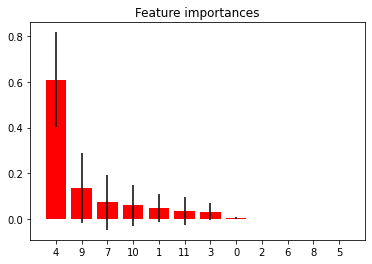

In [43]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]#importanica das arvores ordenada pelo maior valor.

# Print the feature ranking
print("Feature ranking:")
df = pd.DataFrame()
for i, j in zip( x_train_n, forest.feature_importances_ ):
    aux = pd.DataFrame( {'feature': i, 'importance': j}, index=[0] )
    df = pd.concat( [df, aux], axis=0 )
    
print( df.sort_values( 'importance', ascending=False ) )

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(x_train_n.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(x_train_n.shape[1]), indices)
plt.xlim([-1, x_train_n.shape[1]])
plt.show()

> Vamos usar as 7 primeiras features do ranking, pois a partir da setima, a importancia ja cai para menos de 2%. Para um primeiro ciclo de crsping

In [44]:
cols_selected = [ 'vintage', 'annual_premium', 'age', 'region_code', 'previously_insured','policy_sales_channel' ]

x_train = df6[ cols_selected ]
x_val = x_validation[ cols_selected ]
y_val = y_validation.copy()

# 7.0. Machine Learning

## 7.1. KNN(K-Nearest Neighbors)

> KNN: Algoritmo de aprendizadgem supervisionada, classificador onde o aprendizado é baseado “no quão similar” é um dado (um vetor) do outro. O treinamento é formado por vetores de n dimensões.

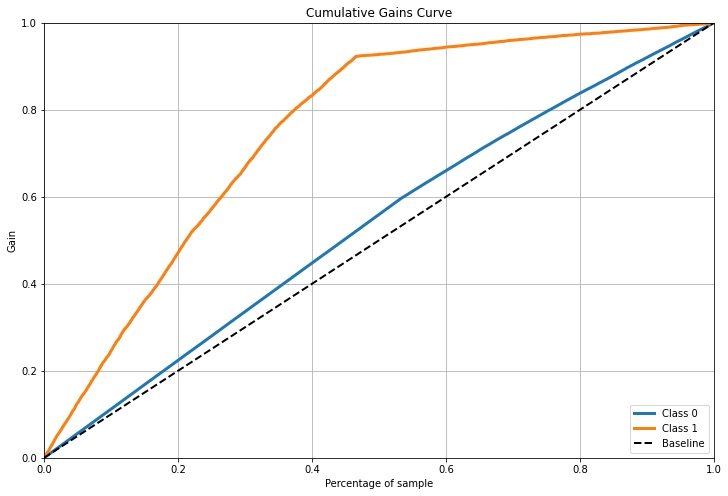

In [69]:
# model definition
knn_model = ng.KNeighborsClassifier( n_neighbors = 10 )

# model training
knn_model.fit( x_train, y_train )

# model prediction - Poder de generalização do modelo. 
yhat_knn = knn_model.predict_proba( x_val )

# Accumulative Gain - metrica de ordenação de lista, plot
skplt.metrics.plot_cumulative_gain( y_val, yhat_knn).figure.set_size_inches(12, 8);

> Significado deste plot, (Linha laranja) é a % de pessoas contactadas da lista 'percentage of sample' são necessárias para obter a % de pessoas interessadas 'gain.  Exemplificando, se contatarmos 20% de nossa amostra, alcancaremos pouco mais de 40% das pessoas interessadas. Linha azul é base desordenada e laranja base ordenada.

## 7.2 Logistic Regression

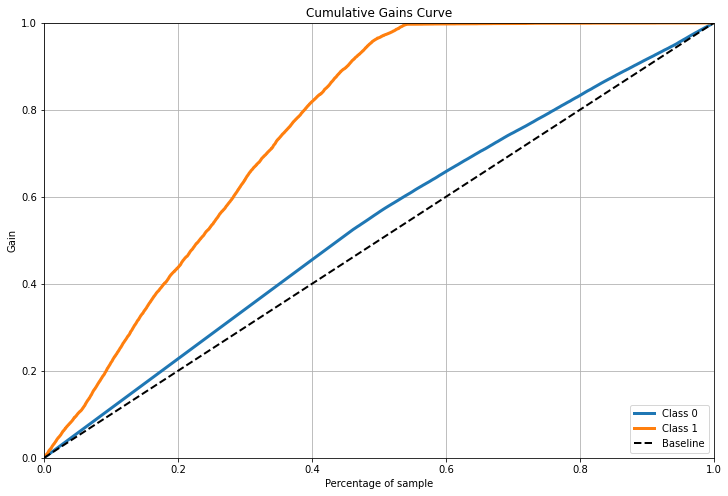

In [46]:
# model definition
lr_model = lm.LogisticRegression( random_state = 42 )

# model training
lr_model.fit( x_train, y_train )

# model prediction - Poder de generalização do modelo. 
yhat_lr = lr_model.predict_proba( x_val )

# Accumulative Gain - metrica de ordenação de lista, plot
skplt.metrics.plot_cumulative_gain( y_val, yhat_lr).figure.set_size_inches(12, 8);

> Os resultados é parecido, porém consegue alcançar 100% da lista com menos pessoas. 

## 7.2 Extra Trees

In [73]:
#model definition
et = en.ExtraTreesClassifier( n_estimators = 1000, n_jobs = -1, random_state = 42, max_depth =6 )

#model fit
et.fit( x_train, y_train )

#model predict
yhat_et = et.predict_proba( x_val )



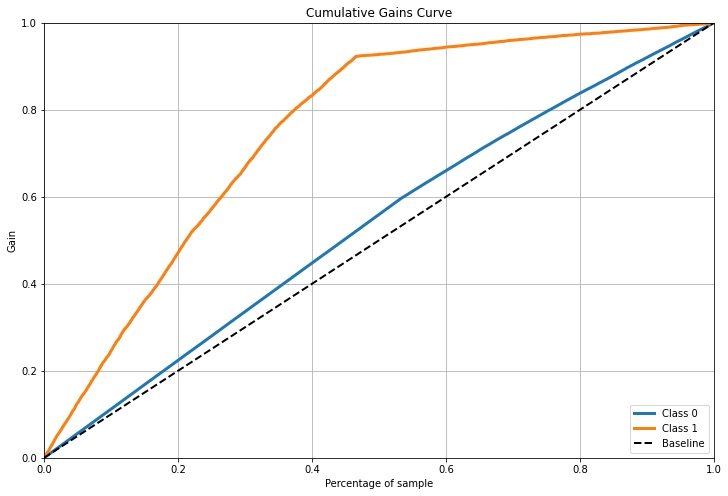

In [48]:
# Accumulative Gain
skplt.metrics.plot_cumulative_gain( y_val, yhat_knn ).figure.set_size_inches(12, 8);

# 8.0 Model performance

In [70]:
def precision_at_k( data, k=2000 ):

    #reset index
    data = data.reset_index( drop = True )

    # create ranking order
    data['ranking'] = data.index + 1

    data['precision_at_k'] = data['response'].cumsum() / data['ranking']
     
    return data.loc[ k , 'precision_at_k']

In [72]:
def recall_at_k( data, k=2000 ):
    
    #reset index
    data = data.reset_index( drop = True )
    
     # create ranking order
    data['ranking'] = data.index + 1
    data['recall_at_k'] = data[ 'response' ].cumsum() / data[ 'response' ].sum()
    
    return data.loc[ k, 'recall_at_k']

In [95]:
#copy data
df8 = x_validation.copy()
df8['response'] = y_validation.copy()

#propensity score
df8['score'] = yhat_knn[:,1].tolist()

#sorte clientes by porpensity score
df8 = df8.sort_values('score', ascending = False )

#Compute precision at k - De todos os K que a predição estimou como verdadeiro, proporção dos que são
precision_at_50 = precision_at_k( df8, k=50 )
print ( 'Precision at k: {:.4}'.format(precision_at_50))

#Compute recall at k - De todos os exemplos que realmente são verdadeiros, quantso eu prdisse ser verdadeiro
recall_at_50 = recall_at_k(df8, k=50 )
print ( 'Recall at k: {:.4}'.format( recall_at_50 ))

Precision at k: 0.3137
Recall at k: 0.001723
